# 3D Forward Simulation of Gravity Anomaly Data

```{admonition} Introductory notebook
:class: hint
This tutorial teaches basic functionality within SimPEG and is a good entry point for new users.
```

```{admonition} Light-weight notebook
:class: hint
This tutorial requires minimal computational resources and can be executed quickly in the background while other computer processes are running.
```

**Author:** Devin C. Cowan

</br>

**Keywords:** gravity survey, gravity anomaly, forward simulation, integral formulation, tensor mesh.

</br>

**Summary:** Here we use the module [SimPEG.potential_fields.gravity](myst:SimPEG#SimPEG.potential_fields.gravity) to simulate gravity anomaly data for a synthetic density contrast model. We use the [3D integral formulation](myst:SimPEG#SimPEG.potential_fields.gravity.Simulation3DIntegral) and carry out the forward simulation on a tensor mesh.

</br>

**Learning Objectives:**

- How to simulate gravity data for 3D structures with SimPEG.
- How to create gravity surveys.
- How to design a tensor mesh for gravity simulation using the integral solution.
- How to predict gravity anomaly data for a density contrast model.
- How to include surface topography in the forward simulation.
- What are the units of the density contrast model and resulting data.

## Import Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise. All of the functionality specific to simulating gravity data are imported from [SimPEG.potential_fields.gravity](myst:SimPEG#SimPEG.potential_fields.gravity). We also import some useful utility functions from [SimPEG.utils](myst:SimPEG#SimPEG.utils). To simulate gravity data, we need to define our problem geometry on a numerical grid (or mesh).
To generate the mesh, we used the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
from SimPEG.potential_fields import gravity
from SimPEG.utils import plot2Ddata, model_builder
from SimPEG import maps

# discretize functionality
from discretize import TensorMesh
from discretize.utils import mkvc, active_from_xyz

# Common Python functionality
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl

mpl.rcParams.update({"font.size": 14})
import matplotlib.pyplot as plt
import os

save_output = False  # Optional

## Define the Topography

Surface topography is defined as an (N, 3) [numpy.ndarray](myst:numpy#numpy.ndarray) for 3D simulations.
Here, we create basic topography for the forward simulation.
For user-specific simulations, you may load topography from an XYZ file.

In [2]:
[x_topo, y_topo] = np.meshgrid(np.linspace(-200, 200, 41), np.linspace(-200, 200, 41))
z_topo = (
    -15 * np.exp(-(x_topo**2 + y_topo**2) / 80**2)
    + 100.0
    + 0.5 * np.random.rand(*x_topo.shape)
)

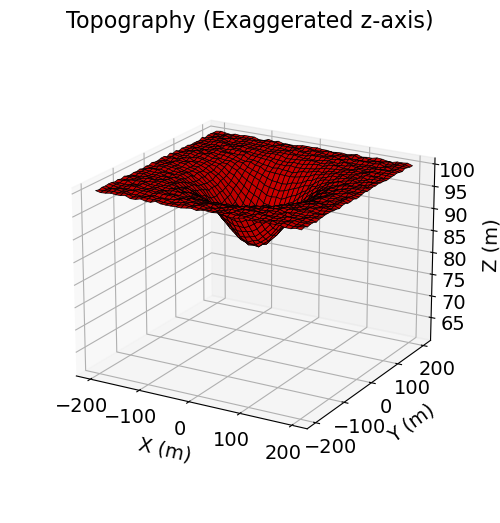

In [3]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection="3d")
ax.set_zlim([z_topo.max() - 40, z_topo.max()])
ax.plot_surface(x_topo, y_topo, z_topo, color="r", edgecolor="k", linewidth=0.5)
ax.set_box_aspect(aspect=None, zoom=0.85)
ax.set_xlabel("X (m)", labelpad=10)
ax.set_ylabel("Y (m)", labelpad=10)
ax.set_zlabel("Z (m)", labelpad=10)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=-20)
ax.view_init(elev=20.0)

In [4]:
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
topo_xyz = np.c_[x_topo, y_topo, z_topo]

## Define the Survey

Surveys within SimPEG generally require the user to create and connect three types of objects:

- [receivers](myst:SimPEG#SimPEG.potential_fields.gravity.receivers.Point): which define the locations of field measurements and type of data being measured.
- [sources](myst:SimPEG#SimPEG.potential_fields.gravity.sources.SourceField): the passive or active sources responsible for generating geophysical responses, and their associated receivers.
- [survey](myst:SimPEG#SimPEG.potential_fields.gravity.survey.Survey): the object which stores and organizes all of the sources and receivers.

Here, we define the survey that will be used for the forward simulation. Gravity
surveys are simple to create. The user only needs an (N, 3) [numpy.ndarray](myst:numpy#numpy.ndarray) to define
the xyz locations of the observation locations, and a list of field components
which are to be measured. For the tutorial simulation, the receivers are located 5 m
above the surface topography and spaced 10 m apart.

In [5]:
# Define the observation locations as an (N, 3) numpy array or load them from a file.
x = np.linspace(-80.0, 80.0, 17)
y = np.linspace(-80.0, 80.0, 17)
x, y = np.meshgrid(x, y)
x, y = mkvc(x.T), mkvc(y.T)
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)
z = fun_interp(np.c_[x, y]) + 5.0
receiver_locations = np.c_[x, y, z]

In [6]:
# Define the component(s) of the field we want to simulate as strings within
# a list. Here we simulate only the vertical component of the gravity anomaly.
components = ["gz"]

# Use the observation locations and components to define receivers for the entire survey
# in one step. The set of receivers, even if it's only 1, are organized within a list.
receiver_list = gravity.receivers.Point(receiver_locations, components=components)
receiver_list = [receiver_list]

# Defining the source. For gravity surveys, we simply need to specific the list of
# receivers associated with the source field.
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Defining the survey.
survey = gravity.survey.Survey(source_field)

If desired, we can extract various objects and properties from the objects used to generate the survey. E.g.

In [7]:
print("# of data: {}".format(survey.nD))  # number of data that will be simulated
print(survey.source_field)  # the source field object
print(survey.source_field.receiver_list[0])  # the receiver object
print(receiver_list[0].locations[:5, :])  # the first 5 receiver locations

# of data: 289
[[-80.         -80.         103.35231778]
 [-70.         -80.         102.57819683]
 [-60.         -80.         101.98613603]
 [-50.         -80.         101.27436248]
 [-40.         -80.         101.10038749]]


## Design a (Tensor) Mesh

Meshes are designed using the [discretize](https://discretize.simpeg.xyz/en/main) package. See the [discretize user tutorials](https://discretize.simpeg.xyz/en/main/tutorials/mesh_generation/index.html) to learn more about creating meshes.
Here, the forward simulation is computed for a [tensor mesh](myst:discretize#discretize.TensorMesh). If you wanted to generate a [tree mesh](myst:discretize#discretize.TreeMesh) instead, you can use the code snippet from the [3D Forward Simulation of Gravity Gradiometry Data](fwd_gravity_gradiometry_3d.ipynb) tutorial.

The integral formulation for gravity essentially sums the independent gravity anomaly contribution for every voxel cell in the mesh. Since the kernel function that computes the contribution for a single cell is an analytic solution, small cells are not required to accurately compute the contributions from coarse structures with constant density (e.g. a rectangular prism). For complex structures however, or to define surface topography more accurately, finer cells may be needed. Furthermore, cells do not need to be cubic.

Here, a core cell width of 5 m is used within our survey region. Padding is used to extend the mesh outside the immediate survey area. The mesh will be plotted after we define our density contrast model.

In [8]:
# Generate tensor mesh with top at z = 0 m
dh = 5.0
hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hz = [(dh, 5, -1.3), (dh, 15)]
mesh = TensorMesh([hx, hy, hz], "CCN")

# Shift vertically to top same as maximum topography
mesh.origin += np.r_[0.0, 0.0, z_topo.max()]

If desired, we can extract various properties of the mesh. E.g.

In [9]:
print("# of cells: {}".format(mesh.n_cells))  # Number of cells
print("# of x-faces: {}".format(mesh.n_faces_x))  # Number of x-faces
print("Origin: {}".format(mesh.origin))  # bottom-southewest corner
print("Max cell volume: {}".format(mesh.cell_volumes.max()))  # Largest cell size
print(mesh.cell_centers[0:5, :])  # Cell center locations

# of cells: 50000
# of x-faces: 51000
Origin: [-158.78015    -158.78015     -33.28236921]
Max cell volume: 6398.236626761349
[[-149.497825   -149.497825    -24.00004421]
 [-133.07525    -149.497825    -24.00004421]
 [-120.4425     -149.497825    -24.00004421]
 [-110.725      -149.497825    -24.00004421]
 [-103.25       -149.497825    -24.00004421]]


## Define the Active Cells

Whereas cells below the Earth's surface contribute towards the simulated gravity anomaly, air cells do not.
The set of mesh cells used in the forward simulation are referred to as 'active cells'. Unused cells (air cells) are 'inactive cells'. Here, the discretize [active_from_xyz](myst:discretize#discretize.utils.active_from_xyz) utility function is used to find the indices of the active cells using the mesh and surface topography. The output quantity is a ``bool`` array.

In [10]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_xyz)

## Mapping from the Model to Active Cells

In SimPEG, the term 'model' is not synonymous with the physical property values defined on the mesh. For example, the model may be defined as the logarithms of the physical property values, or be parameters defining a layered Earth. When simulating gravity anomaly data using the integral formulation, we must define a mapping from the set of model parameters to the active cells in the mesh. Mappings are created using the [SimPEG.maps](myst:SimPEG#SimPEG.maps.IdentityMap) module. For the tutorial exercise, the model is the density contrast values for all active cells. As such, our mapping is an identity mapping, whose dimensions are equal to the number of active cells.

In [11]:
# Define mapping from model to active cells. The model consists of a density
# contrast value for each cell below the Earth's surface.
n_active = int(active_cells.sum())
model_map = maps.IdentityMap(nP=n_active)

## Define the Model

Here, we create the model that will be used to predict gravity anomaly data.
Recall that our model is the density constrast values for all active mesh cells.
So the model is a 1D [numpy.ndarray](myst:numpy#numpy.ndarray) whose length is
equal to the number of model parameters.
**In SimPEG, density contrast values are defined in units of g/cc**.
Here, the model consists of a less dense block and a more dense sphere.
We plot the model using the [plot_slice](myst:discretize#discretize.TensorMesh.plot_slice) method.

In [12]:
# Define density contrast values for each unit in g/cc
background_density = 0.0
block_density = -0.2
sphere_density = 0.2

In [13]:
# Instantiate a vector array.
model = background_density * np.ones(n_active)

# You could find the indicies of specific cells within the model and change their
# values to add structures.
ind_block = (
    (mesh.cell_centers[active_cells, 0] > -50.0)
    & (mesh.cell_centers[active_cells, 0] < -20.0)
    & (mesh.cell_centers[active_cells, 1] > -15.0)
    & (mesh.cell_centers[active_cells, 1] < 15.0)
    & (mesh.cell_centers[active_cells, 2] > 50.0)
    & (mesh.cell_centers[active_cells, 2] < 70.0)
)
model[ind_block] = block_density

# You can also use SimPEG utilities to add structures to the model more concisely
ind_sphere = model_builder.get_indices_sphere(
    np.r_[35.0, 0.0, 60.0], 14.0, mesh.cell_centers
)
ind_sphere = ind_sphere[active_cells]
model[ind_sphere] = sphere_density

In [14]:
# Map for ignoring inactive cells when plotting
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

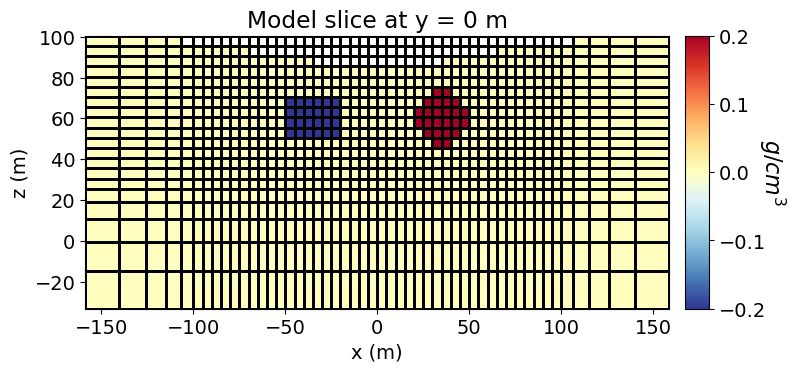

In [15]:
# Plot Density Contrast Model
fig = plt.figure(figsize=(8, 3.5))

ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plot_slice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=True,
    clim=(np.min(model), np.max(model)),
    pcolor_opts={"cmap": mpl.cm.RdYlBu_r},
)
ax1.set_title("Model slice at y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.03, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=16)

plt.show()

## Define the Forward Simulation

In SimPEG, the physics of the forward simulation is defined by creating an instance of an appropriate simulation class.
In this case, we use the simulation class for the [3D integral formulation](myst:SimPEG#SimPEG.potential_fields.gravity.Simulation3DIntegral). To fully define the forward simulation, we need to connect the simulation object to:

- the survey
- the mesh
- the indices of the active cells
- the mapping from the model to the active cells

This is accomplished by setting each one of the aforementioned items as a property of the simulation object.
Additional keyword arguments can also be set which impact the forward simulation.
Because we are only simulating data for a single model, there is no benefit to storing the sensitivities for the forward simulation. As a result, we set the ``store_sensitivities`` property to *'forward_only'*.

In [16]:
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    rhoMap=model_map,
    ind_active=active_cells,
    store_sensitivities="forward_only",
)

## Simulate Gravity Anomaly Data

Once any simulation within SimPEG has been properly constructed, simulated data for a given model vector can be computed using the [dpred](myst:SimPEG#SimPEG.simulation.BaseSimulation.dpred) method. **SimPEG uses a right-handed coordinate system to simulate gravity anomaly data where Z is positive upward!!!** Please be aware of this when using gravity anomaly data to infer the locations of more and less dense structures. E.g. above a more dense block, a negative gravity anomaly is observed because gravity is stronger in the -ve Z direction. In SimPEG, gravity anomaly values are in **units mGal.**

In [17]:
dpred = simulation.dpred(model)

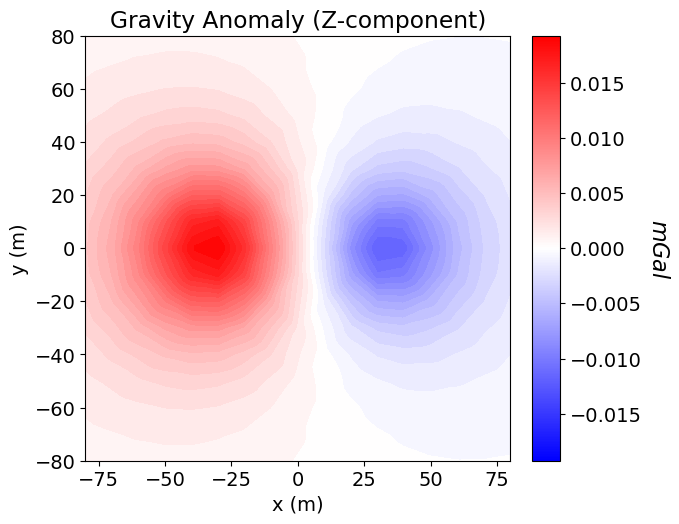

In [18]:
fig = plt.figure(figsize=(7, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

norm = mpl.colors.Normalize(vmin=-np.max(np.abs(dpred)), vmax=np.max(np.abs(dpred)))
plot2Ddata(
    receiver_list[0].locations,
    dpred,
    ax=ax1,
    ncontour=40,
    contourOpts={"cmap": mpl.cm.bwr, "norm": norm},
)
ax1.set_title("Gravity Anomaly (Z-component)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.81, 0.1, 0.04, 0.85])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar.set_label("$mGal$", rotation=270, labelpad=20, size=16)

plt.show()

**Optional:** Exporting the data and topography.

In [19]:
if save_output:
    dir_path = os.path.sep.join([".", "fwd_gravity_anomaly_3d_outputs"]) + os.path.sep
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    fname = dir_path + "gravity_topo.txt"
    np.savetxt(fname, np.c_[topo_xyz], fmt="%.4e")

    np.random.seed(737)
    maximum_anomaly = np.max(np.abs(dpred))
    noise = 0.02 * maximum_anomaly * np.random.normal(size=len(dpred))
    fname = dir_path + "gravity_data.obs"
    np.savetxt(fname, np.c_[receiver_locations, dpred + noise], fmt="%.4e")